# Checkbox Labeling  

Author(s) - Ryan Folks  
Purpose - To label checkboxes using the position of checkboxes.  

---

In [1]:
import sys
import os
sys.path.append(os.path.join("..", "..", "..", "ChartExtractor", "src"))

In [2]:
import json
import random
from PIL import Image, ImageDraw
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm import tqdm
from utilities.annotations import BoundingBox, Point
from utilities.image_conversion import pil_to_cv2, cv2_to_pil
import cv2
import numpy as np
import pandas as pd

In [3]:
Point.__repr__ = lambda self: f"Point({self.x}, {self.y})"

---

## 1 - Load Data

In [4]:
def label_studio_to_bboxes(path_to_json_data: Path) -> List[BoundingBox]:
    json_data: List[Dict] = json.loads(open(str(path_to_json_data)).read())
    return {
        sheet_data['data']['image'].split("-")[-1]:[
            BoundingBox(
                category=label['value']['rectanglelabels'][0],
                left=label['value']['x']/100,
                top=label['value']['y']/100,
                right=label['value']['x']/100+label['value']['width']/100,
                bottom=label['value']['y']/100+label['value']['height']/100,
            )
            for label in sheet_data['annotations'][0]['result']
        ]
        for sheet_data in json_data
    }


data_path: Path = Path("..")/".."/"data"
landmark_location_data: Dict[str, List[BoundingBox]] = label_studio_to_bboxes(data_path/"intraop_document_landmarks.json")
checkbox_location_data: Dict[str, List[BoundingBox]] = label_studio_to_bboxes(data_path/"intraop_checkbox_names.json")

Homography

In [5]:
def homography_transform(
    src_image: Image.Image,
    src_points: List[Tuple[float, float]],
    dest_points: List[Tuple[float, float]],
    original_image_size: Tuple[float, float] = (3300, 2250),
) -> Tuple[List[List[float]], Image.Image]:
    """Performs homography transformation on an image.

    This function transforms an image (src_image) based on corresponding points
    between the source and destination images. It calculates the homography matrix
    and uses it to warp the source image to the perspective of the destination points.

    Args:
        src_image (Image.Image):
            A PIL image object representing the source image.
        src_points (List[Tuple[int, int]]):
            A list of tuples (x, y) representing points in the source image that correspond
            to points in the destination image.
        dest_points (List[Tuple[int, int]]):
            A list of tuples (x, y) representing points in the destination image that points
            in the source image correspond to (where the source image should be warped to).
        original_image_size (Tuple[float, float]):
            A tuple (width, height) representing the size of the control image.
            Defaults to (3300, 2250).

    Returns:
        A PIL image object representing the transformed source image.

    Raises:
        ValueError:
            If the length of src_points and dest_points don't match (must have the same
            number of corresponding points), or if there are less than 4 points.
    """
    src_points: np.ndarray = np.array(src_points)
    dest_points: np.ndarray = np.array(dest_points)

    if len(src_points) != len(dest_points):
        raise ValueError(
            "Source and destination points must have the same number of elements."
        )
    if len(src_points) < 4 or len(dest_points) < 4:
        raise ValueError("Must have 4 or more points to compute the homography.")

    src_image = pil_to_cv2(src_image)
    h, _ = cv2.findHomography(src_points, dest_points)
    dest_image = cv2.warpPerspective(src_image, h, original_image_size)
    return h, cv2_to_pil(dest_image)

In [6]:
sorted(landmark_location_data['unified_intraoperative_preoperative_flowsheet_v1_1_front.png'], key=lambda bb: bb.category)

[BoundingBox(category='anesthesia_start', left=0.01272509471128841, top=0.0074461197571953, right=0.07575473602069113, bottom=0.016866305933318605),
 BoundingBox(category='lateral', left=0.8478774710612861, top=0.9807845444628994, right=0.8745474031974078, bottom=0.9901969156805276),
 BoundingBox(category='safety_checklist', left=0.030913069333097596, top=0.980779480372136, right=0.09272854168786186, bottom=0.9925825938048181),
 BoundingBox(category='units', left=0.9460597274343558, top=0.029801815290808963, right=0.9706124622802825, bottom=0.04156358205163003)]

In [7]:
def bbox_to_points(bbox: BoundingBox):
    return (
        bbox.left + (1/2)*(bbox.right-bbox.left),
        bbox.top + (1/2)*(bbox.bottom-bbox.top)
    )


def get_corresponding_points(bboxes, imsize):
    categories_to_get = ['anesthesia_start', 'lateral', 'safety_checklist', 'units']
    points = list(map(
        bbox_to_points,
        sorted(
            list(filter(lambda bb: bb.category in categories_to_get, bboxes)), 
            key=lambda bb: bb.category
        )
    ))
    return [(p[0]*imsize[0], p[1]*imsize[1]) for p in points]

In [8]:
sheet = "RC_0001_intraoperative.JPG"
img = Image.open(str(data_path/"chart_images"/sheet))
h, transformed_img = homography_transform(
    img, 
    get_corresponding_points(landmark_location_data[sheet], img.size),
    get_corresponding_points(landmark_location_data["unified_intraoperative_preoperative_flowsheet_v1_1_front.png"], (3300, 2250)),
)

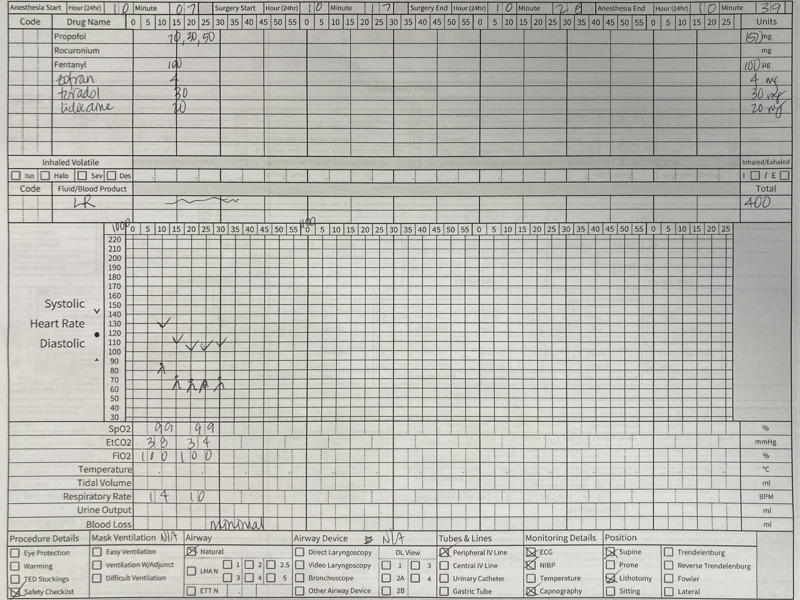

In [9]:
transformed_img.resize((800, 600))

Helpful functions for remapping new points using the homography matrix.

In [10]:
remap_point = lambda p, h: cv2.perspectiveTransform(np.array(p, dtype=np.float32).reshape(-1, 1, 2), h).tolist()[0][0]


def remap_bbox(
    bbox: BoundingBox, 
    h, 
    original_width:int=4032, 
    original_height:int=3024,
    new_width:int=3300,
    new_height:int=2250,
) -> BoundingBox:
    new_left, new_top = remap_point((bbox.left*original_width, bbox.top*original_height), h)
    new_right, new_bottom = remap_point((bbox.right*original_width, bbox.bottom*original_height), h)
    return BoundingBox(bbox.category, new_left/new_width, new_top/new_height, new_right/new_width, new_bottom/new_height)


remap_all_bboxes = lambda bboxes, h: [remap_bbox(bb, h) for bb in bboxes]


locations = landmark_location_data[sheet]
remapped_locations = remap_all_bboxes(locations, h)

Get landmarks that show up only once.

Check labels.

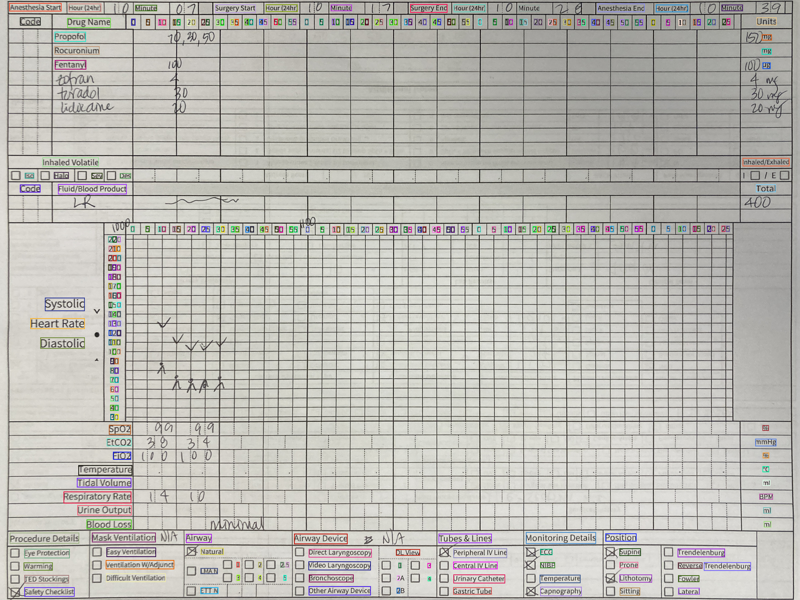

In [11]:
generate_color = lambda: "#%06x" % random.randint(0, 0xFFFFFF)

sheet = "RC_0001_intraoperative.JPG"
img = Image.open(str(data_path/"chart_images"/sheet))
original_width, original_height = img.size
img = transformed_img.copy()
width, height = img.size
draw = ImageDraw.Draw(img)

for bounding_box in remapped_locations:
    box = [
        bounding_box.left*width,
        bounding_box.top*height,
        bounding_box.right*width,
        bounding_box.bottom*height,
    ]
    draw.rectangle(box, outline=generate_color(), width=3)
img.resize((800, 600))

Remap all data

In [12]:
landmark_names = [bb.category for bb in landmark_location_data["RC_0001_intraoperative.JPG"]]
singleton_landmark_names = list(filter(lambda bb_name: landmark_names.count(bb_name) == 1, landmark_names))
singleton_landmark_location_data = {
    k:list(filter(lambda bb: bb.category in singleton_landmark_names, v))
    for (k, v) in landmark_location_data.items()
}

In [13]:
singleton_landmark_location_data

{'unified_intraoperative_preoperative_flowsheet_v1_1_front.png': [BoundingBox(category='anesthesia_start', left=0.01272509471128841, top=0.0074461197571953, right=0.07575473602069113, bottom=0.016866305933318605),
  BoundingBox(category='units', left=0.9460597274343558, top=0.029801815290808963, right=0.9706124622802825, bottom=0.04156358205163003),
  BoundingBox(category='safety_checklist', left=0.030913069333097596, top=0.980779480372136, right=0.09272854168786186, bottom=0.9925825938048181),
  BoundingBox(category='lateral', left=0.8478774710612861, top=0.9807845444628994, right=0.8745474031974078, bottom=0.9901969156805276)],
 'RC_0001_intraoperative.JPG': [BoundingBox(category='micro_g', left=0.885347, top=0.14174599999999998, right=0.894449, bottom=0.15103799999999998),
  BoundingBox(category='mmHg', left=0.889846, top=0.7150265, right=0.91368, bottom=0.7256415),
  BoundingBox(category='degree_C', left=0.8989705000000001, top=0.756528, right=0.9064355000000002, bottom=0.765324),


In [14]:
remapped_data = dict()
remapped_checkboxes = dict()
for im_name, boxes in tqdm(singleton_landmark_location_data.items()):
    if im_name=="unified_intraoperative_preoperative_flowsheet_v1_1_front.png":
        continue
    img = Image.open(str(data_path/"chart_images"/im_name))
    h, transformed_img = homography_transform(
        img, 
        get_corresponding_points(boxes, img.size),
        get_corresponding_points(singleton_landmark_location_data["unified_intraoperative_preoperative_flowsheet_v1_1_front.png"], (3300, 2250)),
    )
    remapped_boxes = remap_all_bboxes(boxes, h)
    try:
        remapped_cboxs = remap_all_bboxes(checkbox_location_data[im_name], h)
    except:
        pass
    remapped_data[im_name] = remapped_boxes
    remapped_checkboxes[im_name] = remapped_cboxs

100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


In [15]:
remapped_data

{'RC_0001_intraoperative.JPG': [BoundingBox(category='micro_g', left=0.9530448774857955, top=0.10416385226779513, right=0.9630803148674243, bottom=0.11472284613715278),
  BoundingBox(category='mmHg', left=0.9440855823863636, top=0.7314392903645833, right=0.9705877130681818, bottom=0.7438025716145833),
  BoundingBox(category='degree_C', left=0.9533182410037879, top=0.7769386393229166, right=0.9614825254498106, bottom=0.7867615559895833),
  BoundingBox(category='BPM', left=0.949366640033144, top=0.82270068359375, right=0.9663537967566288, bottom=0.8326334092881944),
  BoundingBox(category='anesthesia_start', left=0.011641346324573863, top=0.005321658240424262, right=0.07682115959398675, bottom=0.01898714362250434),
  BoundingBox(category='surgery_start', left=0.2690050159801136, top=0.007450124104817708, right=0.3195602139559659, bottom=0.02168270026312934),
  BoundingBox(category='surgery_end', left=0.5129358649976326, top=0.006737216101752387, right=0.5593124112215909, bottom=0.0212301

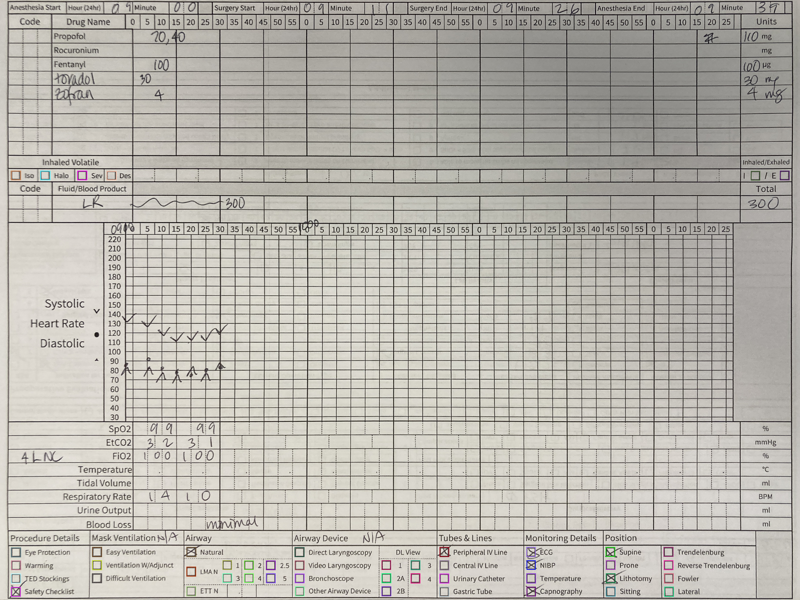

In [16]:
generate_color = lambda: "#%06x" % random.randint(0, 0xFFFFFF)

sheet = "RC_0005_intraoperative.JPG"
img = Image.open(str(data_path/"chart_images"/sheet))


_, img = homography_transform(
    img, 
    get_corresponding_points(landmark_location_data[sheet], img.size), 
    get_corresponding_points(landmark_location_data["unified_intraoperative_preoperative_flowsheet_v1_1_front.png"], (3300, 2250))
)
original_width, original_height = img.size
width, height = img.size
draw = ImageDraw.Draw(img)

for bounding_box in remapped_checkboxes[sheet]:
    box = [
        bounding_box.left*width,
        bounding_box.top*height,
        bounding_box.right*width,
        bounding_box.bottom*height,
    ]
    draw.rectangle(box, outline=generate_color(), width=3)
img.resize((800, 600))

In [17]:
remapped_checkboxes

{'RC_0001_intraoperative.JPG': [BoundingBox(category='isoflurane', left=0.013191366484670928, top=0.28420751953125, right=0.026062753850763495, bottom=0.30075244140625),
  BoundingBox(category='halothane', left=0.05035098913944129, top=0.28436018880208336, right=0.06262573704575047, bottom=0.30080330403645833),
  BoundingBox(category='sevoflurane', left=0.09646668405243845, top=0.2844689127604167, right=0.10897066058534564, bottom=0.3009670681423611),
  BoundingBox(category='desflurane', left=0.1332210656368371, top=0.2845572102864583, right=0.1454372891512784, bottom=0.30070277235243054),
  BoundingBox(category='inhaled', left=0.9378834487452652, top=0.28425721571180557, right=0.94992431640625, bottom=0.30058846028645836),
  BoundingBox(category='exhaled', left=0.9744967743844697, top=0.28393115234375, right=0.9867675041429924, bottom=0.3003606499565972),
  BoundingBox(category='eye_protection', left=0.01242217323996804, top=0.9134869791666667, right=0.02477418379350142, bottom=0.9298

## 2 - Investingating Clustering

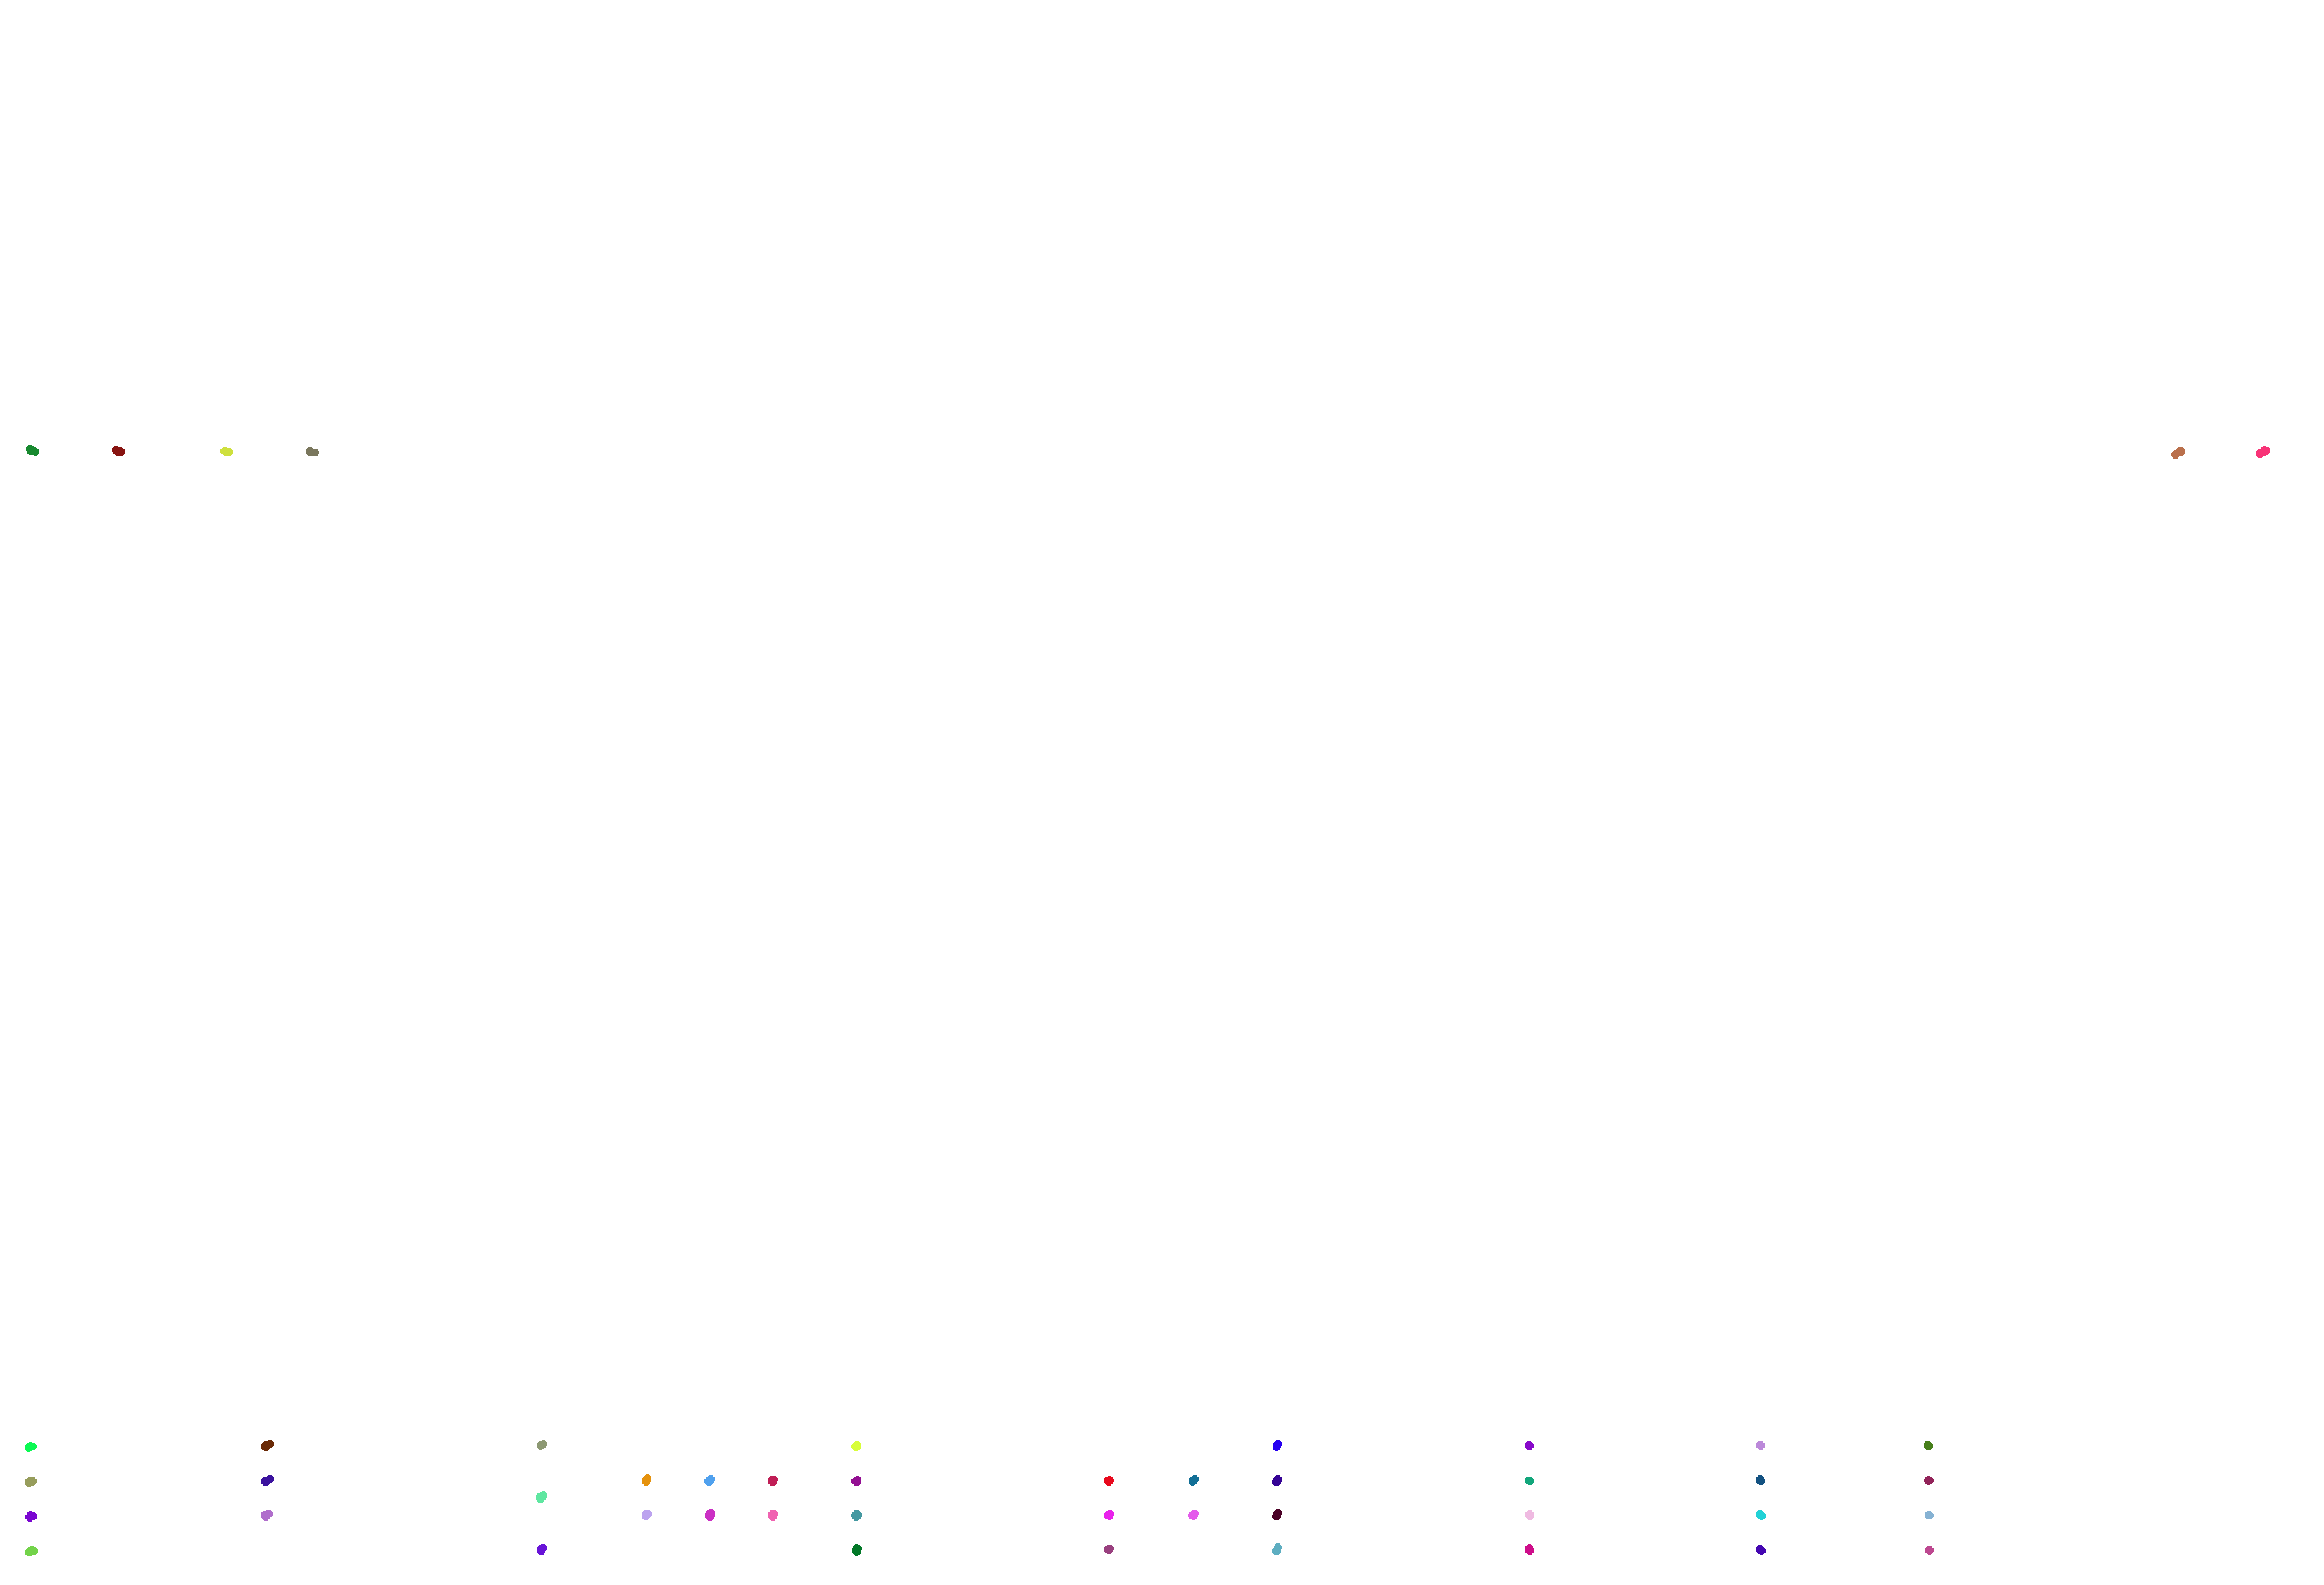

In [18]:
all_checkboxes_list = [item for sublist in [v for v in remapped_checkboxes.values()] for item in sublist]
checkbox_names = list(set([bb.category for bb in all_checkboxes_list]))
checkbox_name_to_color_map = {name:generate_color() for name in checkbox_names}

WIDTH, HEIGHT = 3300, 2250
im = Image.new(mode="RGB", size=(WIDTH, HEIGHT), color='white')
draw = ImageDraw.Draw(im)
POINT_SIZE = 5
for checkbox in all_checkboxes_list:
    x, y, _, _ = checkbox.box
    x, y = x*WIDTH, y*HEIGHT
    draw.ellipse(
        (x-POINT_SIZE, y-POINT_SIZE, x+POINT_SIZE, y+POINT_SIZE),
        fill=checkbox_name_to_color_map[checkbox.category],
        outline=checkbox_name_to_color_map[checkbox.category]
    )
im

In [19]:
from sklearn.cluster import KMeans

In [20]:
len(remapped_checkboxes[list(remapped_checkboxes.keys())[0]])

47

In [21]:
all_checkboxes_list

[BoundingBox(category='isoflurane', left=0.013191366484670928, top=0.28420751953125, right=0.026062753850763495, bottom=0.30075244140625),
 BoundingBox(category='halothane', left=0.05035098913944129, top=0.28436018880208336, right=0.06262573704575047, bottom=0.30080330403645833),
 BoundingBox(category='sevoflurane', left=0.09646668405243845, top=0.2844689127604167, right=0.10897066058534564, bottom=0.3009670681423611),
 BoundingBox(category='desflurane', left=0.1332210656368371, top=0.2845572102864583, right=0.1454372891512784, bottom=0.30070277235243054),
 BoundingBox(category='inhaled', left=0.9378834487452652, top=0.28425721571180557, right=0.94992431640625, bottom=0.30058846028645836),
 BoundingBox(category='exhaled', left=0.9744967743844697, top=0.28393115234375, right=0.9867675041429924, bottom=0.3003606499565972),
 BoundingBox(category='eye_protection', left=0.01242217323996804, top=0.9134869791666667, right=0.02477418379350142, bottom=0.9298758680555556),
 BoundingBox(category=

In [22]:
checkbox_clusterer = KMeans(n_clusters=47, n_init="auto", random_state=0).fit(np.array([ckbx.center for ckbx in all_checkboxes_list]))

C:\Users\vcz2aj\AppData\Local\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [23]:
name_to_cluster_id_map = {
    v:k
    for (k, v) in list(set(
        sorted(
            [
                (cluster, box.category) 
                for (cluster, box) in list(zip(checkbox_clusterer.labels_.tolist(), all_checkboxes_list))
            ], key=lambda l: l[0]
        )
    ))
}
cluster_id_to_name_map = {v:k for (k, v) in name_to_cluster_id_map.items()}

In [24]:
for box in tqdm(all_checkboxes_list):
    prediction = checkbox_clusterer.predict([np.array(box.center)])
    true = name_to_cluster_id_map[box.category]
    if prediction != true:
        print("ERROR")
        print(box.category)
        print(f"Predicted: {prediction[0]}")
        print(f"True: {true}")

100%|██████████| 893/893 [00:47<00:00, 18.71it/s]
